In [1]:
import os
import sys
import json
import torch
import torchvision
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm
from transformers import BertModel, BertTokenizer

w_dir = %pwd
work_dir = os.path.dirname(w_dir)
work_dir

I0409 03:31:35.284584 140644095129408 file_utils.py:39] PyTorch version 1.1.0 available.


'/work'

In [2]:
sys.path.append(w_dir+'/fgc_support_retri')

In [3]:
from fgc_support_retri.ser_extractor import *
from fgc_support_retri.utils import *
from fgc_support_retri import config
from fgc_support_retri.evaluation.fgc_eval import *
from fgc_support_retri.evaluation.eval import eval_sp_fgc, eval_fgc_atype

# Extract se

In [4]:
model_name = "20200408_amatch_sf" 

In [5]:
model_folder = config.TRAINED_MODELS / model_name

In [6]:
model_folder

PosixPath('/work/fgc_support_retri/results/trainedmodels/20200408_amatch_sf')

In [8]:
extractor = AMatch_extractor(model_folder, "sf")

I0409 03:32:19.110354 140644095129408 tokenization_utils.py:375] loading file https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-chinese-vocab.txt from cache at /root/.cache/torch/transformers/8a0c070123c1f794c42a29c6904beb7c1b8715741e235bee04aca2c7636fc83f.9b42061518a39ca00b8b52059fd2bede8daa613f8a8671500e518a8c29de8c00
I0409 03:32:20.060270 140644095129408 configuration_utils.py:152] loading configuration file https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-chinese-config.json from cache at /root/.cache/torch/transformers/8a3b1cfe5da58286e12a0f5d7d182b8d6eca88c08e26c332ee3817548cf7e60a.3767c74c8ed285531d04153fe84a0791672aff52f7249b27df341dbce09b8305
I0409 03:32:20.062856 140644095129408 configuration_utils.py:169] Model config {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "directionality": "bidi",
  "finetuning_task": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_r

In [9]:
eval_data = json_load(config.FGC_DEV)

In [10]:
get_answer_sp(eval_data, force=True)

100%|██████████| 247/247 [00:00<00:00, 19984.05it/s]

D097Q08
{'text': '\n3月至8月：顾问审查小名单。', 'start': 481, 'end': 496, 'IE': {'NER': [{'id': 'D0-S0-M0', 'string': '3月', 'type': 'DATE', 'char_b': 1, 'char_e': 3}, {'id': 'D0-S0-M1', 'string': '至', 'type': 'MISC', 'char_b': 3, 'char_e': 4}, {'id': 'D0-S0-M2', 'string': '8月', 'type': 'DATE', 'char_b': 4, 'char_e': 6}, {'id': 'D0-S0-M3', 'string': '顾问', 'type': 'TITLE', 'char_b': 7, 'char_e': 9}], 'COREF': {}, 'RELATION': [], 'TOKEN': [{'word': '3月', 'char_b': 1, 'char_e': 3, 'pos': 'NT'}, {'word': '至', 'char_b': 3, 'char_e': 4, 'pos': 'CC'}, {'word': '8月', 'char_b': 4, 'char_e': 6, 'pos': 'NT'}, {'word': '：', 'char_b': 6, 'char_e': 7, 'pos': 'PU'}, {'word': '顾问', 'char_b': 7, 'char_e': 9, 'pos': 'NN'}, {'word': '审查', 'char_b': 9, 'char_e': 11, 'pos': 'VV'}, {'word': '小', 'char_b': 11, 'char_e': 12, 'pos': 'JJ'}, {'word': '名单', 'char_b': 12, 'char_e': 14, 'pos': 'NN'}, {'word': '。', 'char_b': 14, 'char_e': 15, 'pos': 'PU'}]}}
{'text': '10月', 'text_cn': '10月', 'start': 495, 'end': 498}
D097Q09
{'

In [11]:
all_sp_predictions = []
all_atype_predictions = []
all_items = []
for d in tqdm(eval_data):
    for q in d['QUESTIONS']:
        if not q['SHINT_']:
            continue
        sp_preds = []
        sp_scores = []
        sp_preds, _, sp_scores = extractor.predict_stage1(q, d)
        assert sp_preds != []
        assert sp_scores != []
        q['sp'] = sp_preds
        q['sp_scores'] = sp_scores

100%|██████████| 247/247 [03:12<00:00,  1.18it/s]


In [12]:
all_items, all_sp_predictions, all_answer_sp = eval_from_threshold(eval_data, threshold=0.5)

100%|██████████| 247/247 [00:00<00:00, 40170.34it/s]


In [13]:
metrics = eval_sp_fgc(all_items, all_sp_predictions)

{'sp_em': 0.151, 'sp_prec': 0.61, 'sp_recall': 0.665, 'sp_f1': 0.582}


In [14]:
metrics = eval_sp_fgc(all_answer_sp, all_sp_predictions)

{'sp_em': 0.142, 'sp_prec': 0.392, 'sp_recall': 0.65, 'sp_f1': 0.441}


# Write analysis

In [15]:
def write_analysis(fname, data):
    f=open(config.PREDICTION_PATH / fname, 'w')
    f.write(get_analysis(data))
    f.close()

In [16]:
write_analysis(model_name +'.txt', eval_data)

# Draw intervals

In [18]:
def get_interval_span():
    intervals = []
    last = 0
    step = 10
    for i in range(step):
        now = round(last+1/step, 1)
        intervals.append((last, now))
        last = now
    return intervals

In [19]:
def get_interval(score):
    # get interval span
    intervals = []
    last = 0
    step = 10
    for i in range(step):
        now = round(last+1/step, 1)
        intervals.append((last, now))
        last = now
    
    # get interv_i
    for interv_i, interv in enumerate(intervals):
        if interv[0] <= score < interv[1]:
            return interv_i

In [20]:
def createLabels(data):
    all_height = 0
    for item in data:
        all_height += item.get_height()
    for item in data:
        height = item.get_height()
        plt.text(
            item.get_x()+item.get_width()/2., 
            height*1.05, 
            '{}% ({})'.format(int(height/all_height*100), int(height)),
            ha = "center",
            va = "bottom",
        )

In [21]:
intervals = get_interval_span()

In [22]:
intervals

[(0, 0.1),
 (0.1, 0.2),
 (0.2, 0.3),
 (0.3, 0.4),
 (0.4, 0.5),
 (0.5, 0.6),
 (0.6, 0.7),
 (0.7, 0.8),
 (0.8, 0.9),
 (0.9, 1.0)]

In [23]:
interv_scores_p = [0] * 10
interv_scores_n = [0] * 10
interv_scores_answer = [0] * 10
interv_scores_not_answer = [0] * 10

low_score_data = set()

for d_i, document in enumerate(eval_data):
    for question in document['QUESTIONS']:
        if not question['SHINT_']:
            continue
        for sent_i, sp_score in enumerate(question['sp_scores']):
            if sent_i in question['SHINT_']:
                interv_scores_p[get_interval(sp_score)] += 1
                if sent_i in question['answer_sp']:
                    interv_scores_answer[get_interval(sp_score)] += 1
                    if get_interval(sp_score) == 0 or get_interval(sp_score) == 1:
                        low_score_data.add(d_i)
                else:
                    interv_scores_not_answer[get_interval(sp_score)] += 1
            else:
                interv_scores_n[get_interval(sp_score)] += 1

In [24]:
interv_scores_p

[108, 22, 39, 17, 22, 22, 26, 48, 86, 157]

I0409 03:19:59.916036 140713923802944 category.py:225] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
I0409 03:19:59.918638 140713923802944 category.py:225] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


Text(0.5, 1.0, 'all se')

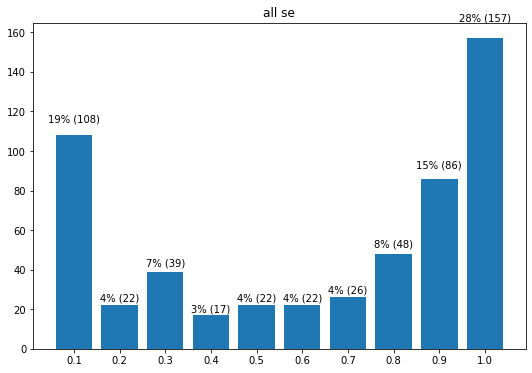

In [25]:
plt.figure(figsize=(30, 6))
plt.subplot(131)
A = plt.bar([str(interv[1]) for interv in intervals], interv_scores_p)
createLabels(A)
plt.title('all se')

I0409 03:20:00.245388 140713923802944 category.py:225] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
I0409 03:20:00.247700 140713923802944 category.py:225] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


Text(0.5, 1.0, 'not se')

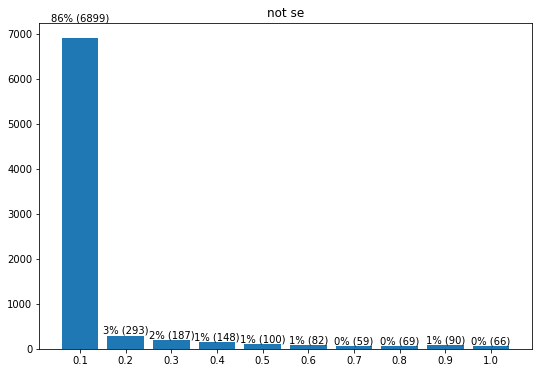

In [26]:
plt.figure(figsize=(30, 6))
plt.subplot(131)
B = plt.bar([str(interv[1]) for interv in intervals], interv_scores_n)
createLabels(B)
plt.title('not se')

I0409 03:20:00.730676 140713923802944 category.py:225] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
I0409 03:20:00.732843 140713923802944 category.py:225] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


Text(0.5, 1.0, 'answer se')

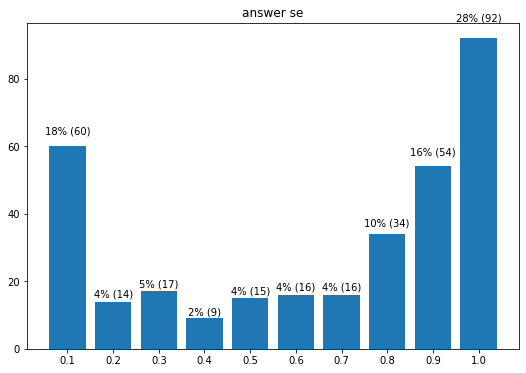

In [27]:
plt.figure(figsize=(30, 6))
plt.subplot(131)
B = plt.bar([str(interv[1]) for interv in intervals], interv_scores_answer)
createLabels(B)
plt.title('answer se')

I0409 03:20:01.027205 140713923802944 category.py:225] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
I0409 03:20:01.029019 140713923802944 category.py:225] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


Text(0.5, 1.0, 'not answer se')

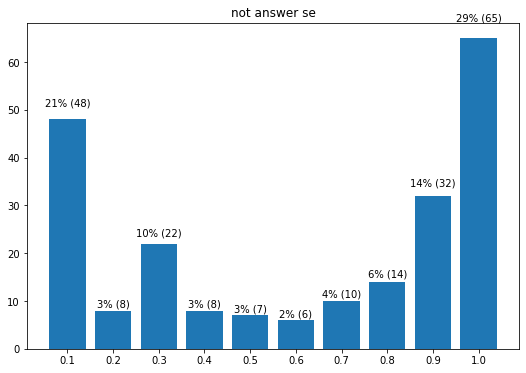

In [28]:
plt.figure(figsize=(30, 6))
plt.subplot(131)
B = plt.bar([str(interv[1]) for interv in intervals], interv_scores_not_answer)
createLabels(B)
plt.title('not answer se')

In [23]:
low_score_eval_data = [eval_data[i] for i in low_score_data]

In [36]:
json_write(low_score_eval_data, 'prediction/ematch+sf_dev_low_answer_se.json')